In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML

from typing import Tuple, List, Sequence, Optional, Union
from pathlib import Path
import re
import torch
import tokenizers as tk
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from torchvision import transforms
from torch import nn, Tensor
from functools import partial
from bs4 import BeautifulSoup as bs
import warnings

from src.model import EncoderDecoder, ImgLinearBackbone, Encoder, Decoder
from src.utils import subsequent_mask, pred_token_within_range, greedy_sampling, bbox_str_to_token_list, cell_str_to_token_list, html_str_to_token_list, build_table_from_html_and_cell, html_table_template
from src.trainer.utils import VALID_HTML_TOKEN, VALID_BBOX_TOKEN, INVALID_CELL_TOKEN

warnings.filterwarnings('ignore')
device = torch.device("cuda:0")

In [2]:
# Check all model weights have been downloaded to experiments/unitable_weights
MODEL_FILE_NAME = ["unitable_large_structure.pt", "unitable_large_bbox.pt", "unitable_large_content.pt"]
MODEL_DIR = Path("../experiments/unitable_weights")

assert all([(MODEL_DIR / name).is_file() for name in MODEL_FILE_NAME]), f"Please download model weights from HuggingFace: https://huggingface.co/poloclub/UniTable/tree/main"

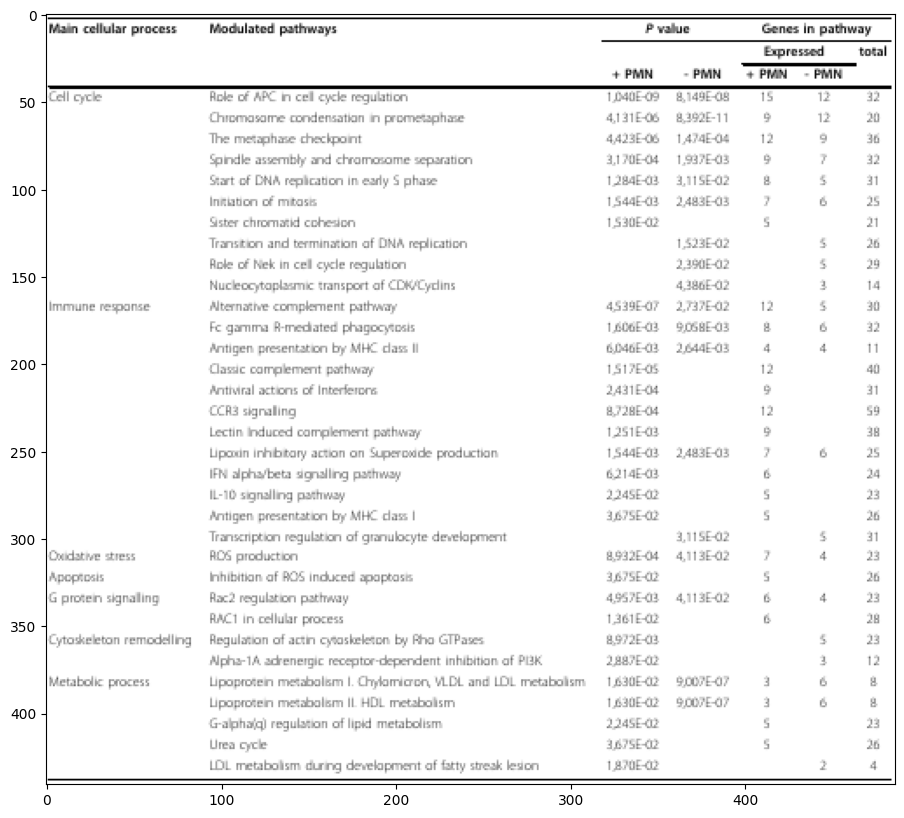

In [3]:
# Load tabular image
image_name = "PMC2838834_005_00.png"
image_path = f"../dataset/mini_pubtabnet/train/{image_name}"
image = Image.open(image_path).convert("RGB")
image_size = image.size

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(image)

In [4]:
# UniTable large model
d_model = 768
patch_size = 16
nhead = 12
dropout = 0.2

backbone = ImgLinearBackbone(d_model=d_model, patch_size=patch_size)
encoder = Encoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=12,
    ff_ratio=4,
)
decoder = Decoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=4,
    ff_ratio=4,
)

In [5]:
def autoregressive_decode(
    model: EncoderDecoder,
    image: Tensor,
    prefix: Sequence[int],
    max_decode_len: int,
    eos_id: int,
    token_whitelist: Optional[Sequence[int]] = None,
    token_blacklist: Optional[Sequence[int]] = None,
) -> Tensor:
    model.eval()
    with torch.no_grad():
        memory = model.encode(image)
        context = torch.tensor(prefix, dtype=torch.int32).repeat(image.shape[0], 1).to(device)

    for _ in range(max_decode_len):
        eos_flag = [eos_id in k for k in context]
        if all(eos_flag):
            break

        with torch.no_grad():
            causal_mask = subsequent_mask(context.shape[1]).to(device)
            logits = model.decode(
                memory, context, tgt_mask=causal_mask, tgt_padding_mask=None
            )
            logits = model.generator(logits)[:, -1, :]

        logits = pred_token_within_range(
            logits.detach(),
            white_list=token_whitelist,
            black_list=token_blacklist,
        )

        next_probs, next_tokens = greedy_sampling(logits)
        context = torch.cat([context, next_tokens], dim=1)
    return context

def load_vocab_and_model(
    vocab_path: Union[str, Path],
    max_seq_len: int,
    model_weights: Union[str, Path],
) -> Tuple[tk.Tokenizer, EncoderDecoder]:
    vocab = tk.Tokenizer.from_file(vocab_path)
    model = EncoderDecoder(
        backbone=backbone,
        encoder=encoder,
        decoder=decoder,
        vocab_size=vocab.get_vocab_size(),
        d_model=d_model,
        padding_idx=vocab.token_to_id("<pad>"),
        max_seq_len=max_seq_len,
        dropout=dropout,
        norm_layer=partial(nn.LayerNorm, eps=1e-6)
    )

    model.load_state_dict(torch.load(model_weights, map_location="cpu"))
    model = model.to(device)
    return vocab, model

def image_to_tensor(image: Image, size: Tuple[int, int]) -> Tensor:
    T = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.86597056,0.88463002,0.87491087], std = [0.20686628,0.18201602,0.18485524])
    ])
    image_tensor = T(image)
    image_tensor = image_tensor.to(device).unsqueeze(0)

    return image_tensor

def rescale_bbox(
    bbox: Sequence[Sequence[float]],
    src: Tuple[int, int],
    tgt: Tuple[int, int]
) -> Sequence[Sequence[float]]:
    assert len(src) == len(tgt) == 2
    ratio = [tgt[0] / src[0], tgt[1] / src[1]] * 2
    bbox = [[int(round(i * j)) for i, j in zip(entry, ratio)] for entry in bbox]
    return bbox

In [ ]:
# Table structure extraction
vocab, model = load_vocab_and_model(
    vocab_path="../vocab/vocab_html.json",
    max_seq_len=784,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[0],
)

# Image transformation
image_tensor = image_to_tensor(image, size=(448, 448))

# Inference
pred_html = autoregressive_decode(
    model=model,
    image=image_tensor,
    prefix=[vocab.token_to_id("[html]")],
    max_decode_len=512,
    eos_id=vocab.token_to_id("<eos>"),
    token_whitelist=[vocab.token_to_id(i) for i in VALID_HTML_TOKEN],
    token_blacklist = None
)

# Convert token id to token text
pred_html = pred_html.detach().cpu().numpy()[0]
pred_html = vocab.decode(pred_html, skip_special_tokens=False)
pred_html = html_str_to_token_list(pred_html)

# print(pred_html)

In [ ]:
# Table cell bbox detection
vocab, model = load_vocab_and_model(
    vocab_path="../vocab/vocab_bbox.json",
    max_seq_len=1024,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[1],
)

# Image transformation
image_tensor = image_to_tensor(image, size=(448, 448))

# Inference
pred_bbox = autoregressive_decode(
    model=model,
    image=image_tensor,
    prefix=[vocab.token_to_id("[bbox]")],
    max_decode_len=1024,
    eos_id=vocab.token_to_id("<eos>"),
    token_whitelist=[vocab.token_to_id(i) for i in VALID_BBOX_TOKEN[: 449]],
    token_blacklist = None
)

# Convert token id to token text
pred_bbox = pred_bbox.detach().cpu().numpy()[0]
pred_bbox = vocab.decode(pred_bbox, skip_special_tokens=False)

# print(pred_bbox)

In [ ]:
# Visualize detected bbox
pred_bbox = bbox_str_to_token_list(pred_bbox)
pred_bbox = rescale_bbox(pred_bbox, src=(448, 448), tgt=image_size)

fig, ax = plt.subplots(figsize=(12, 10))
for i in pred_bbox:
    rect = patches.Rectangle(i[:2], i[2] - i[0], i[3] - i[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
ax.set_axis_off()
ax.imshow(image)

In [ ]:
# Table cell content recognition
vocab, model = load_vocab_and_model(
    vocab_path="../vocab/vocab_cell_6k.json",
    max_seq_len=200,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[2],
)

# Cell image cropping and transformation
image_tensor = [image_to_tensor(image.crop(bbox), size=(112, 448)) for bbox in pred_bbox]
image_tensor = torch.cat(image_tensor, dim=0)

# Inference
pred_cell = autoregressive_decode(
    model=model,
    image=image_tensor,
    prefix=[vocab.token_to_id("[cell]")],
    max_decode_len=200,
    eos_id=vocab.token_to_id("<eos>"),
    token_whitelist=None,
    token_blacklist = [vocab.token_to_id(i) for i in INVALID_CELL_TOKEN]
)

# Convert token id to token text
pred_cell = pred_cell.detach().cpu().numpy()
pred_cell = vocab.decode_batch(pred_cell, skip_special_tokens=False)
pred_cell = [cell_str_to_token_list(i) for i in pred_cell]
pred_cell = [re.sub(r'(\d).\s+(\d)', r'\1.\2', i) for i in pred_cell]

# print(pred_cell)

In [ ]:
# Combine the table structure and cell content
pred_code = build_table_from_html_and_cell(pred_html, pred_cell)
pred_code = "".join(pred_code)
pred_code = html_table_template(pred_code)

# Display the HTML table
soup = bs(pred_code)
table_code = soup.prettify()
display(HTML(table_code))

In [ ]:
# Raw HTML table code
print(table_code)

## Evaluation - Proceed only if you have the groundtruth annotation.

In [ ]:
from src.utils.teds import TEDS
import jsonlines
from src.vocab.constant import CELL_SPECIAL

In [ ]:
# Load groundtruth annotation
annotation_path = "../dataset/mini_pubtabnet/mini_pubtabnet_examples.jsonl"
with jsonlines.open(annotation_path) as f:
    for obj in f:
        if obj["filename"] == image_name:
            anno_html_raw = obj["html"]["structure"]["tokens"]
            anno_cell_raw = ["".join(cell["tokens"]) for cell in obj["html"]["cells"] if cell["tokens"]]
            break

anno_html = []
idx = 0
while idx < len(anno_html_raw):
    if "[" in anno_html_raw[idx]:
        assert idx + 1 < len(anno_html_raw)
        assert anno_html_raw[idx + 1] == "]</td>"
        anno_html.append(anno_html_raw[idx] + "]</td>")
        idx = idx + 2
    else:
        anno_html.append(anno_html_raw[idx])
        idx = idx + 1

anno_cell = []
for txt in anno_cell_raw:
    for black in CELL_SPECIAL:
        txt = txt.replace(black, "")
    anno_cell.append(txt)

anno_code = "".join(build_table_from_html_and_cell(anno_html, anno_cell))

In [ ]:
# Evaluate table structure only (S-TEDS)
teds = TEDS(structure_only=True)
teds.evaluate(pred_code, html_table_template(anno_code))

In [ ]:
# Evaluate both table structure and cell content (TEDS)
teds = TEDS(structure_only=False)
teds.evaluate(pred_code, html_table_template(anno_code))